In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'flickr8k' dataset.
Path to dataset files: /kaggle/input/flickr8k


In [4]:
images_directory = '/kaggle/input/flickr8k/Images/'
captions_path = '/kaggle/input/flickr8k/captions.txt'
def load_captions(file_path):
    # Check if the file exists before trying to open it
    if not os.path.exists(file_path):
        print(f"Error: The file '{file_path}' was not found.")
        print("Please ensure the 'flickr8k' dataset is correctly uploaded or mounted in your Colab environment.")
        # Return an empty list to prevent further errors
        return []
    with open(file_path, 'r') as f:
        captions = f.readlines()
        captions = [caption.lower() for caption in captions[1:]]
    return captions

def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

captions = load_captions(captions_path)

# Only proceed with tokenization and display if captions were successfully loaded
if captions:
    # tokenizer = tokenize_captions(captions) # Uncomment if you want to tokenize after successful load
    print("Captions loaded successfully. Here are some examples:")
    print(captions[:15:3])
else:
    print("Captions could not be loaded. Please address the file path error.")

Captions loaded successfully. Here are some examples:
['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n', '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n', '1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road .\n', '1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .\n', '1002674143_1b742ab4b8.jpg,a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .\n']


In [5]:
import re

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
cleaned_captions[:15:2]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a little girl climbing into a wooden playhouse',
 'a little girl in a pink dress going into a wooden cabin',
 'a black dog and a tricolored dog playing with each other on the road',
 'two dogs of different breeds looking at each other on the road',
 'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'young girl with pigtails painting outside in the grass']

In [6]:
captions_IDs = []
for i in range(len(cleaned_captions)):
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append(item)

captions_IDs[:20:3], len(captions_IDs)

(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

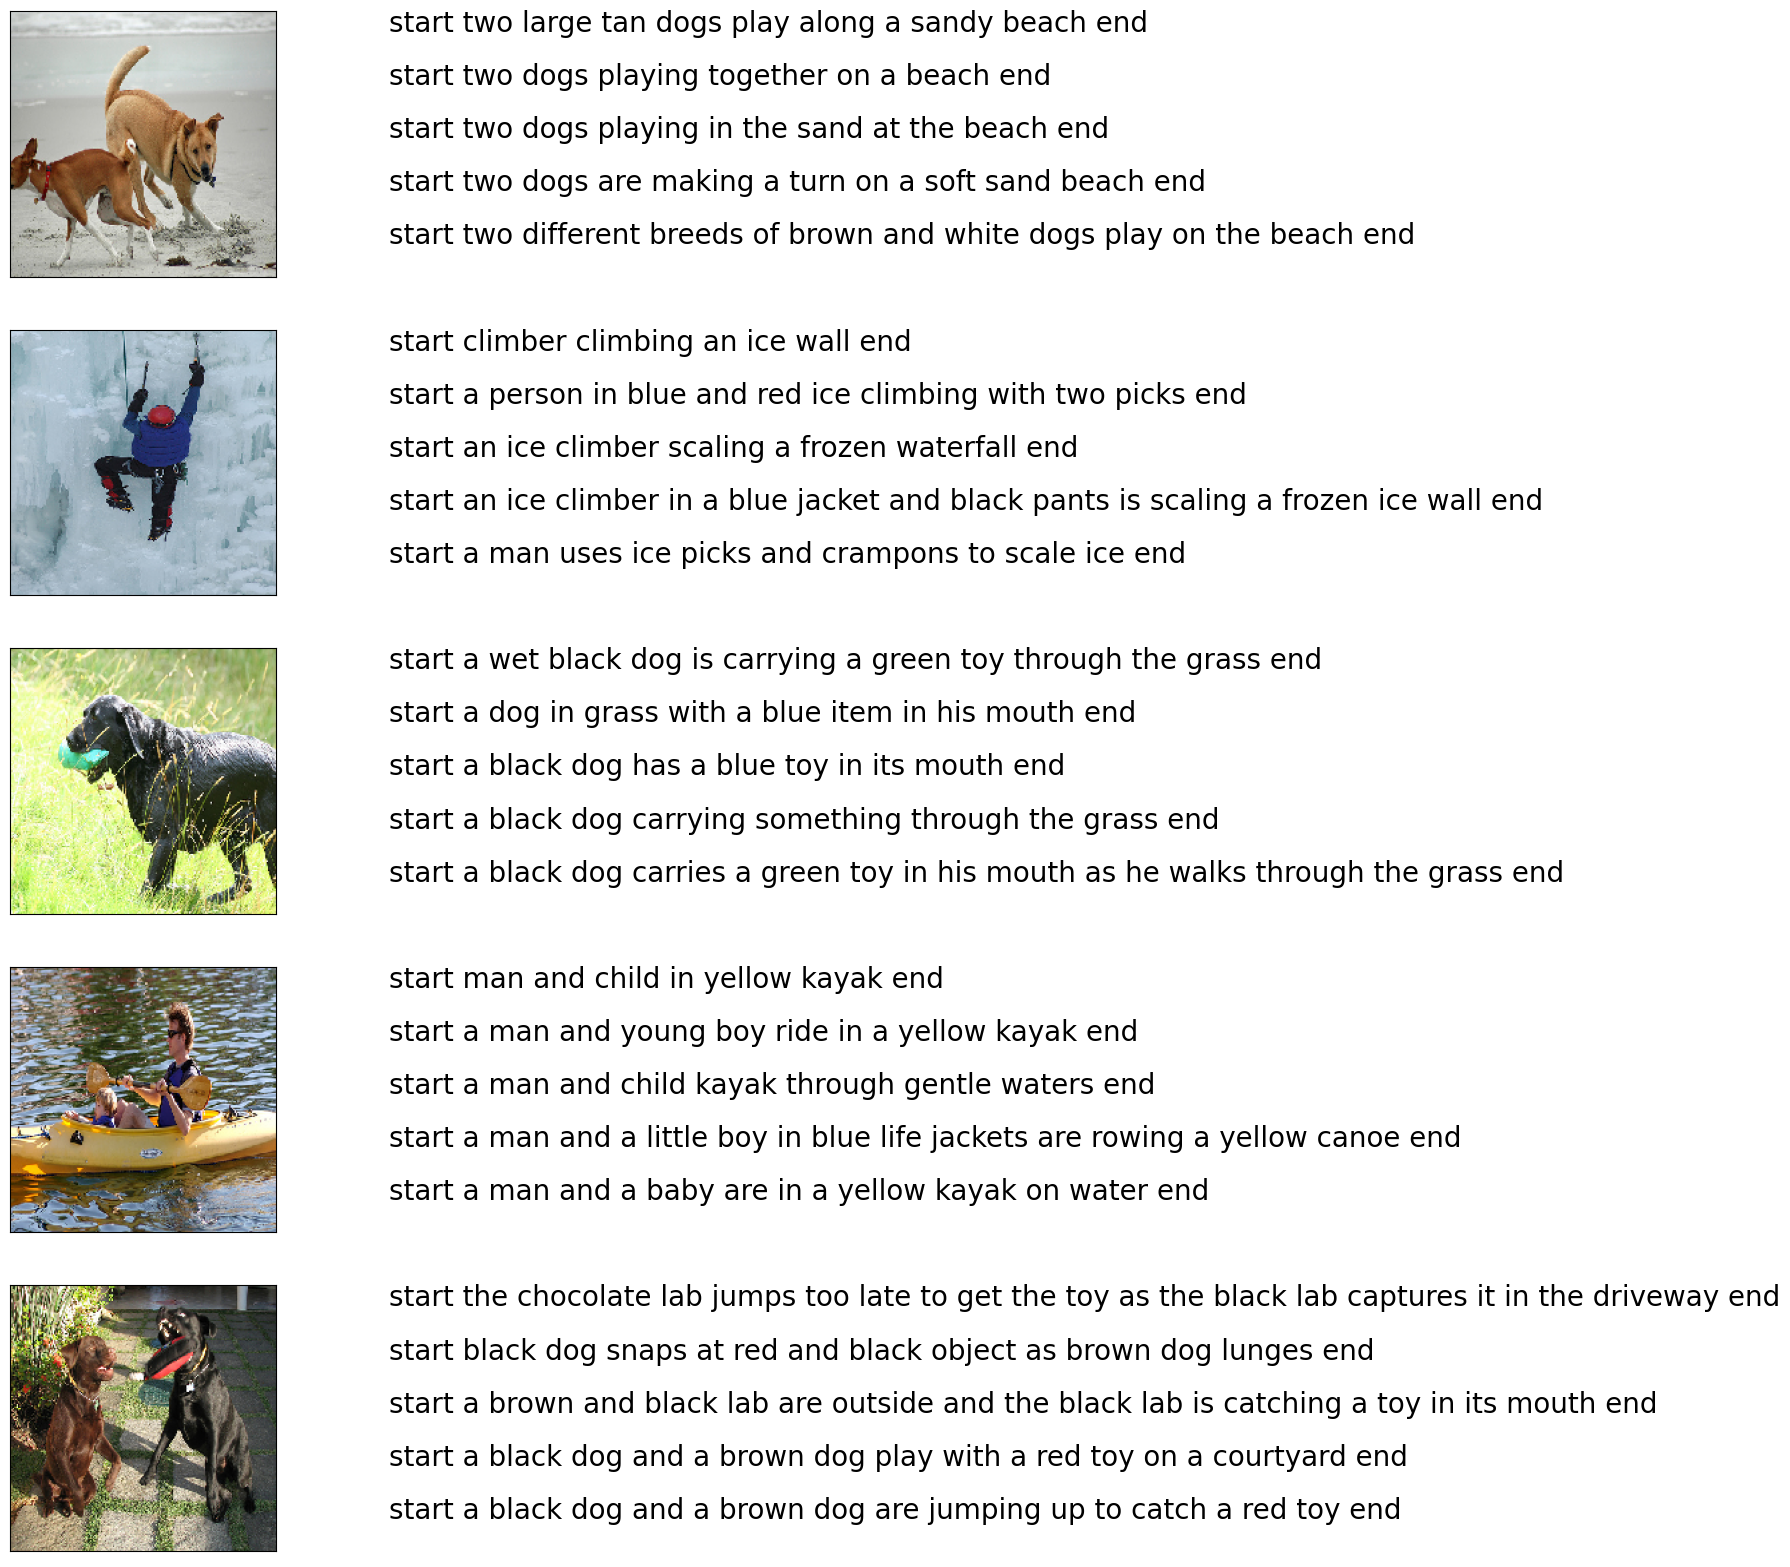

In [7]:
def visualaization(data, num_of_images):
    captions_dictionary = {}
    for item in data[100:100+(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)
    else:
        list_captions = [x for x in captions_dictionary.items()]

    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(captions_dictionary.keys()):
        captions = captions_dictionary[filename]
        image_load = load_img(images_directory+filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()

visualaization(captions_IDs, 5)

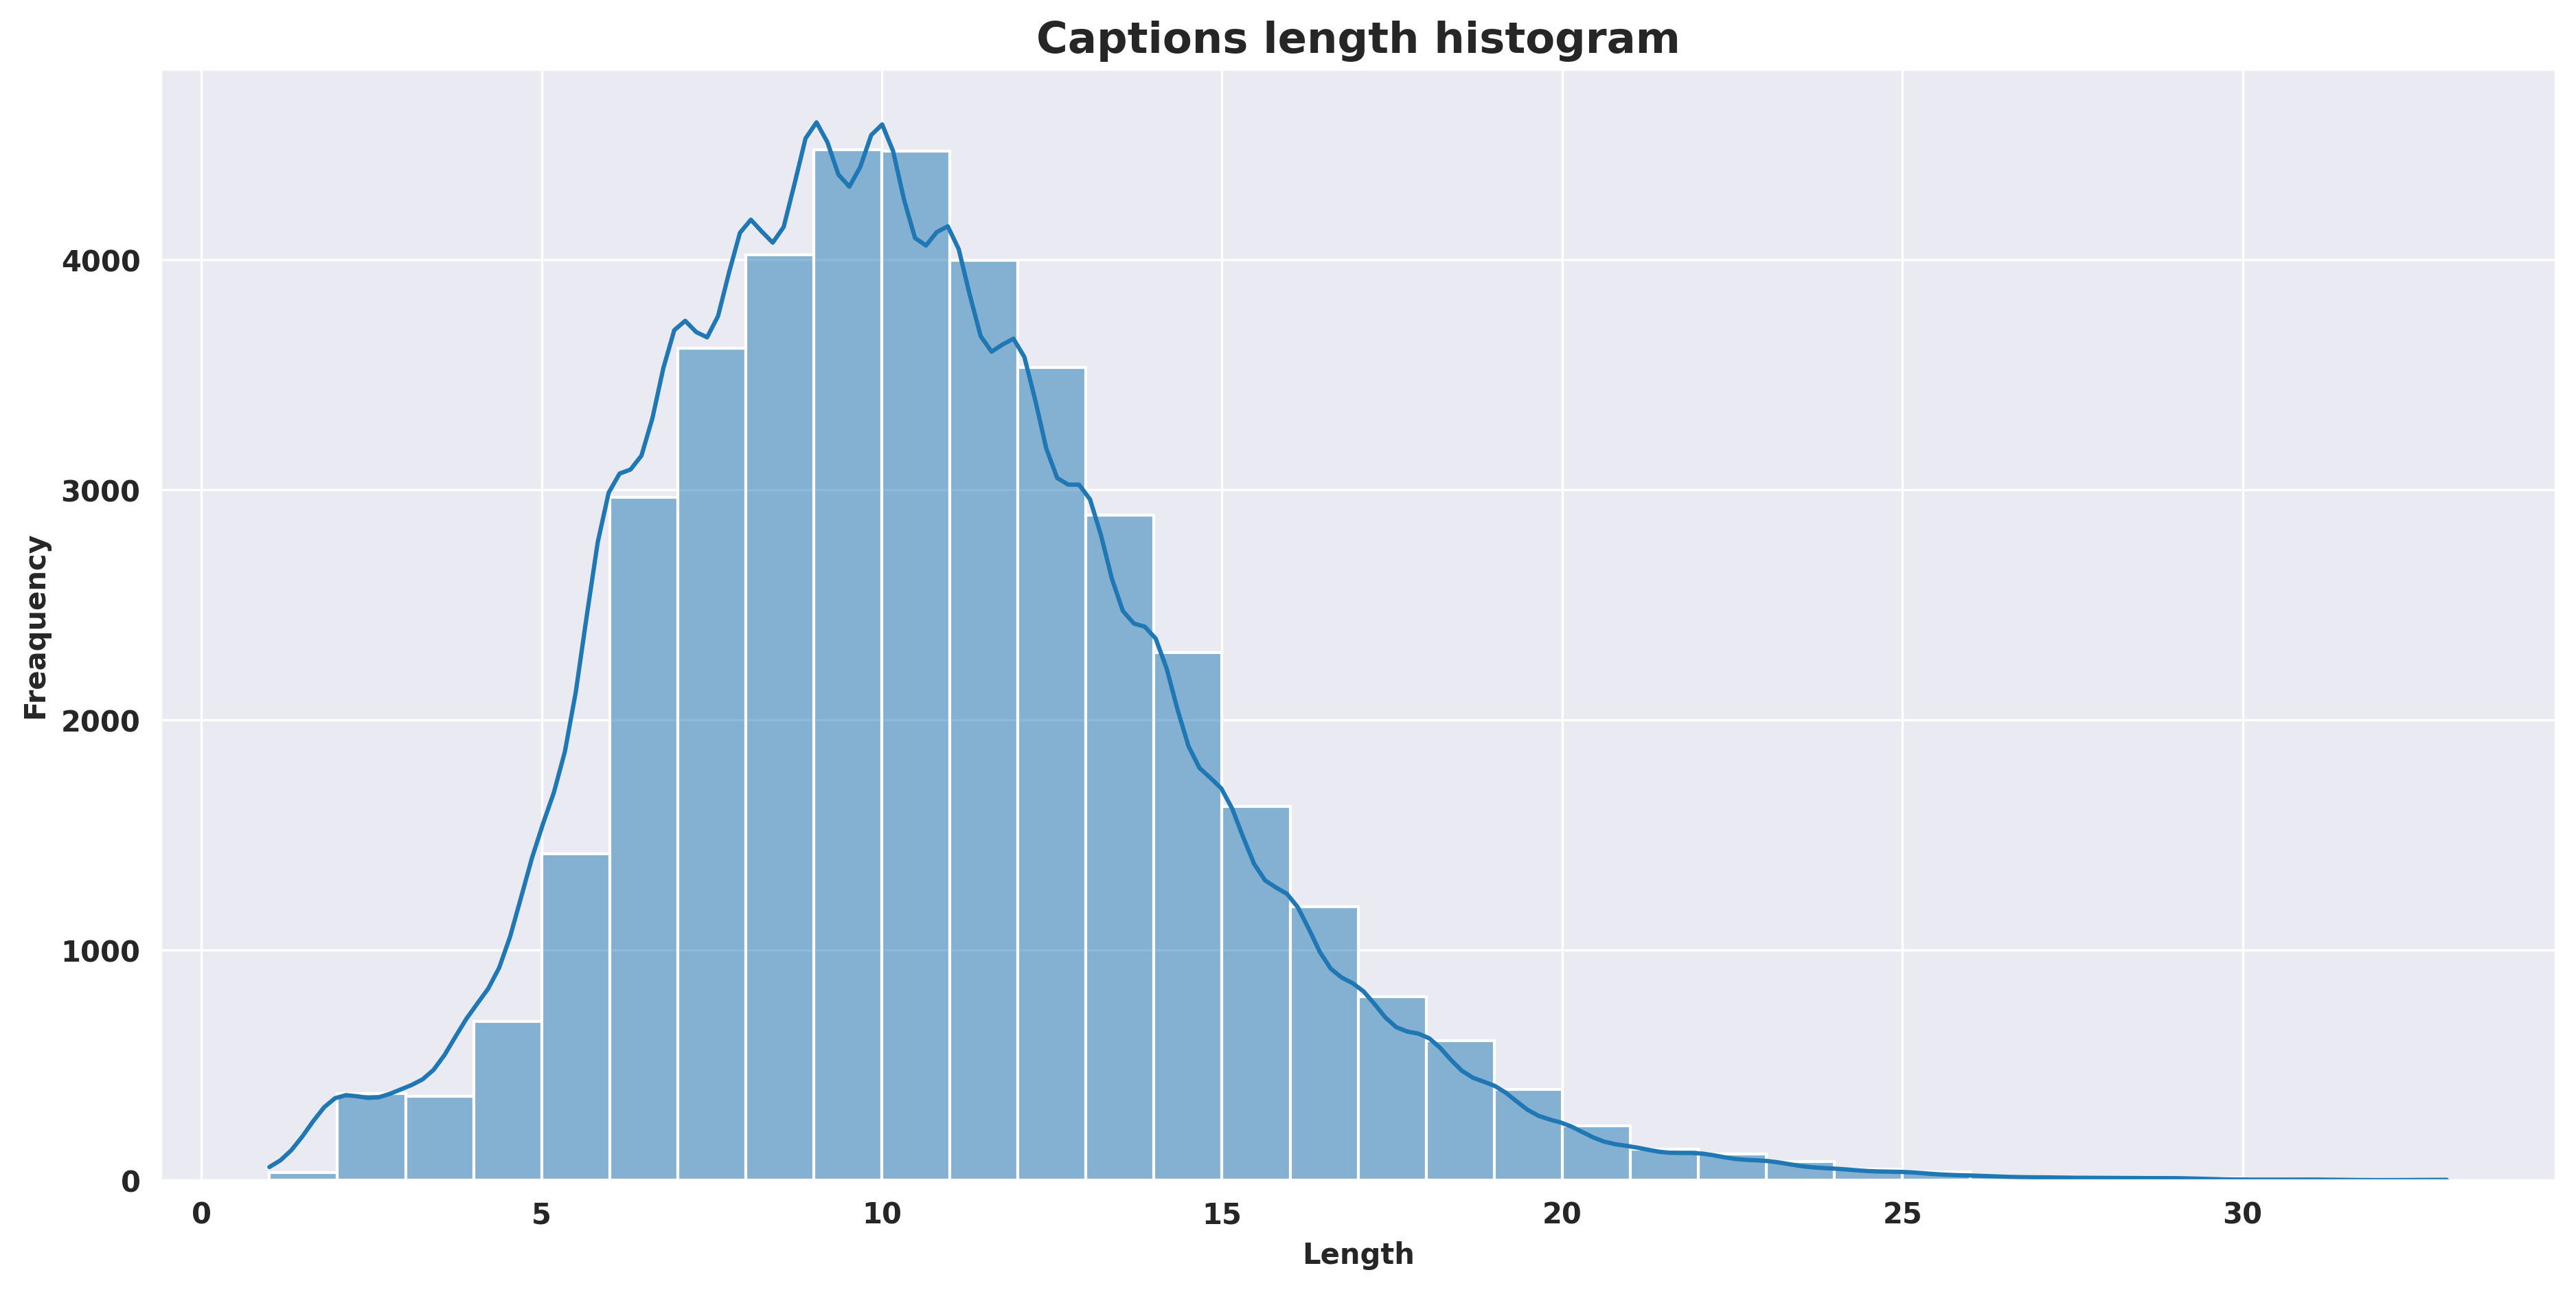

In [8]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1)
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()

captions_length(cleaned_captions)

In [9]:
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8586

In [10]:
all_image_ids = os.listdir(images_directory)

train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')

    if image_id in train_image_ids:
        train_captions.append(caption)

    elif image_id in val_image_ids:
        val_captions.append(caption)

    elif image_id in test_image_ids:
        test_captions.append(caption)

    else:
        print('Unknown image ID !')

train_captions[0], val_captions[0], test_captions[0], len(train_captions)/5, len(val_captions)/5, len(test_captions)/5

('1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
 '1001773457_577c3a7d70.jpg\tstart a black dog and a spotted dog are fighting end\n',
 '1042590306_95dea0916c.jpg\tstart a man and woman pose for the camera while another man looks on end\n',
 6877.0,
 1092.0,
 122.0)

In [11]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0)
    return features

inception_v3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
inception_v3_model.layers.pop()
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [12]:
train_image_features, val_image_features, test_image_features = {}, {}, {}  # A Dictionary to store image features with their corresponding IDs

pbar = tqdm_notebook(total=len(all_image_ids), position=0, leave=True, colour='green')

for caption in all_image_ids:
    image_id = caption.split('\t')[0]
    image_path = os.path.join(images_directory, image_id)
    image_features = extract_image_features(inception_v3_model, image_path) # Extracting features

    if image_id in train_image_ids:
        train_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    elif image_id in val_image_ids:
        val_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    elif image_id in test_image_ids:
        test_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    else:
        print('Unknown image ID !')

pbar.close()

  0%|          | 0/8091 [00:00<?, ?it/s]

In [13]:
import os

save_dir = '/content/drive/MyDrive/image_features'
os.makedirs(save_dir, exist_ok=True)


In [14]:
import pickle

# Save train features
with open(os.path.join(save_dir, 'train_image_features.pkl'), 'wb') as f:
    pickle.dump(train_image_features, f)

# Save validation features
with open(os.path.join(save_dir, 'val_image_features.pkl'), 'wb') as f:
    pickle.dump(val_image_features, f)

# Save test features
with open(os.path.join(save_dir, 'test_image_features.pkl'), 'wb') as f:
    pickle.dump(test_image_features, f)

print("✅ Features saved to Google Drive successfully!")


✅ Features saved to Google Drive successfully!


In [15]:
# How to Load Them Later from Drive
# with open('/content/drive/MyDrive/image_features/train_image_features.pkl', 'rb') as f:
#     train_image_features = pickle.load(f)


In [16]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        np.random.shuffle(image_ids)  # Shuffle image_ids for each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer.texts_to_sequences([caption_text])[0] # Tokenizing the caption
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i] # X_caption, Y
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)

            yield (np.array(X_images), np.array(X_captions)), np.array(y)


max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1

cnn_output_dim = inception_v3_model.output_shape[1] # 2048

batch_size_train = 270
batch_size_val = 150

train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)

In [21]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1) # Adding a Dense layer to the CNN output to match the decoder output size
    fe3 = BatchNormalization()(fe2)

    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256, use_cudnn=False)(se1) # Added use_cudnn=False

    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model

caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

caption_model.summary()

Model: "Image_Captioning"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Features_Input      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ Features_Input[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Sequence_Input      │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    524,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 34, 256)   │  2,198,016 │ Sequence_Input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 34)        │          0 │ Sequence_Input[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ embedding_1[0][0… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 8586)      │  2,206,602 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,529,482 (21.09 MB)

 Trainable params: 5,524,874 (21.08 MB)

 Non-trainable params: 4,608 (18.00 KB)

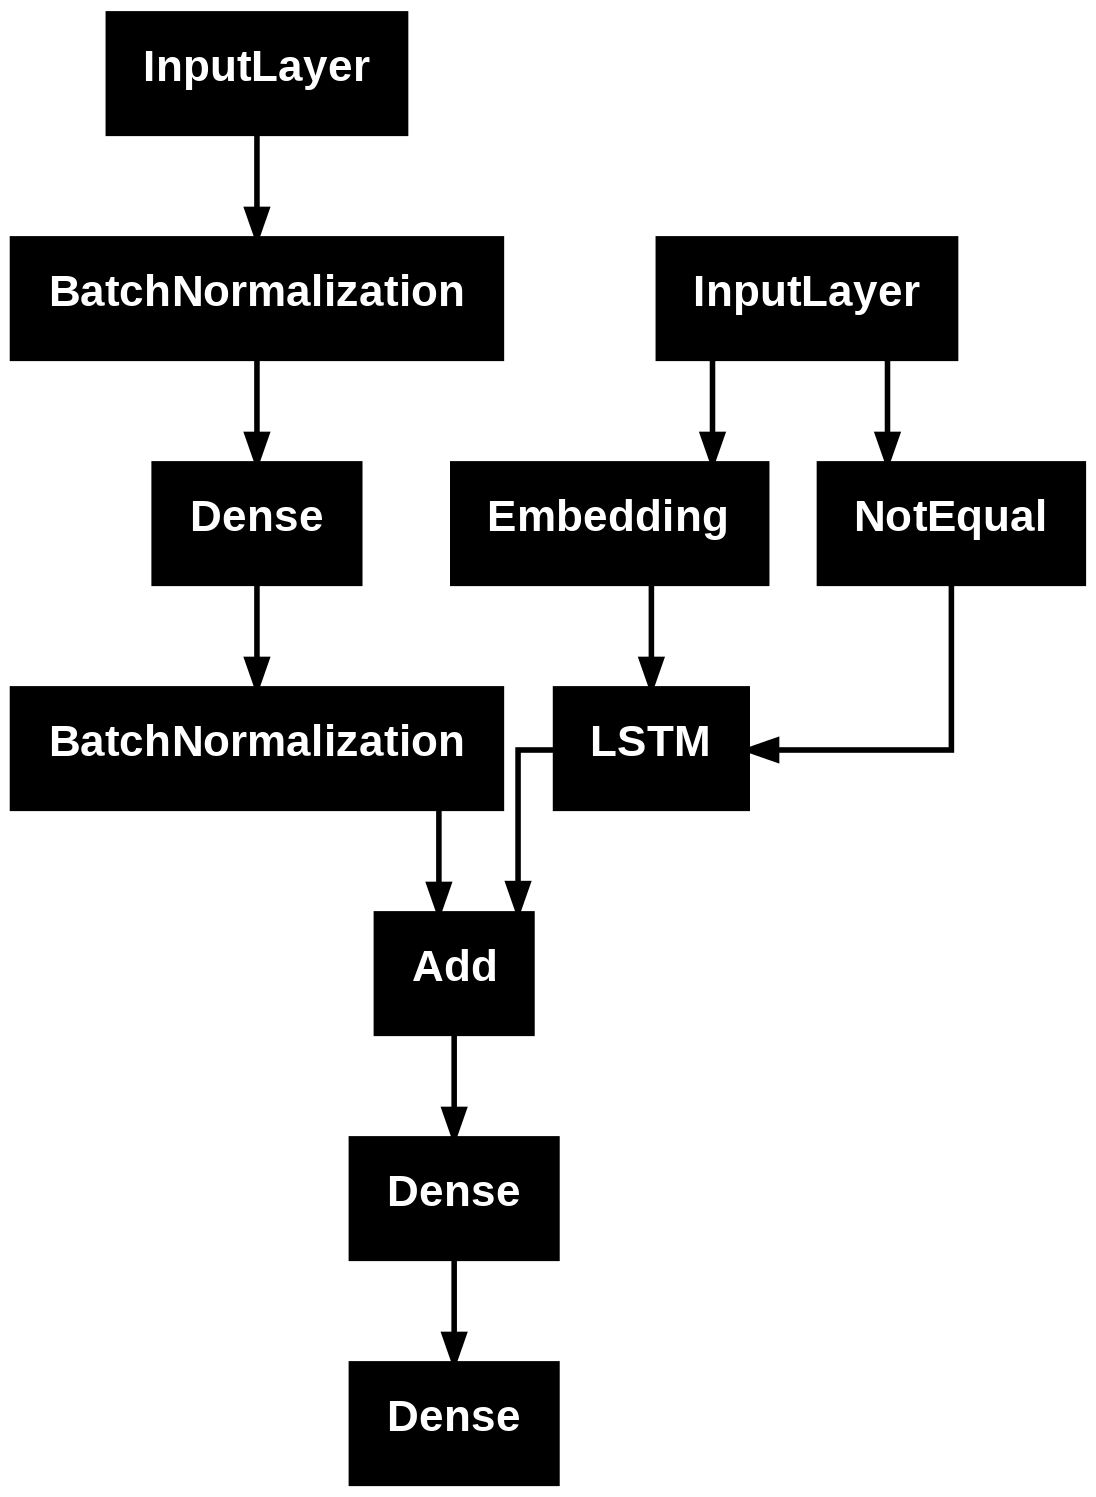

In [22]:
plot_model(caption_model)

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    # Ensure the returned value is a standard Python float
    return lr * float(tf.math.exp(-0.6))

lr_schedule = LearningRateScheduler(lr_scheduler)

history = caption_model.fit(train_data_generator, steps_per_epoch=len(train_captions) // batch_size_train,
                        validation_data=val_data_generator, validation_steps=len(val_captions) // batch_size_val,
                        epochs=15, callbacks=[early_stopping, lr_schedule])

Epoch 1/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 579s 5s/step - loss: 5.2439 - val_loss: 3.7352 - learning_rate: 0.0055
Epoch 2/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 60s 475ms/step - loss: 3.3953 - val_loss: 3.3996 - learning_rate: 0.0030
Epoch 3/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 61s 479ms/step - loss: 2.9852 - val_loss: 3.2978 - learning_rate: 0.0017
Epoch 4/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 60s 474ms/step - loss: 2.7607 - val_loss: 3.2454 - learning_rate: 9.0718e-04
Epoch 5/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 80s 629ms/step - loss: 2.6168 - val_loss: 3.2560 - learning_rate: 4.9787e-04
Epoch 6/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 60s 479ms/step - loss: 2.5274 - val_loss: 3.2594 - learning_rate: 2.7324e-04
Epoch 7/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 60s 475ms/step - loss: 2.4802 - val_loss: 3.2504 - learning_rate: 1.4996e-04


In [24]:
caption_model.save('/content/caption_model_final.h5')


In [26]:
caption_model.save('/content/drive/MyDrive/model/caption_model_final.keras')

In [27]:
caption_model.save('/content/drive/MyDrive/model/caption_model_final.h5')


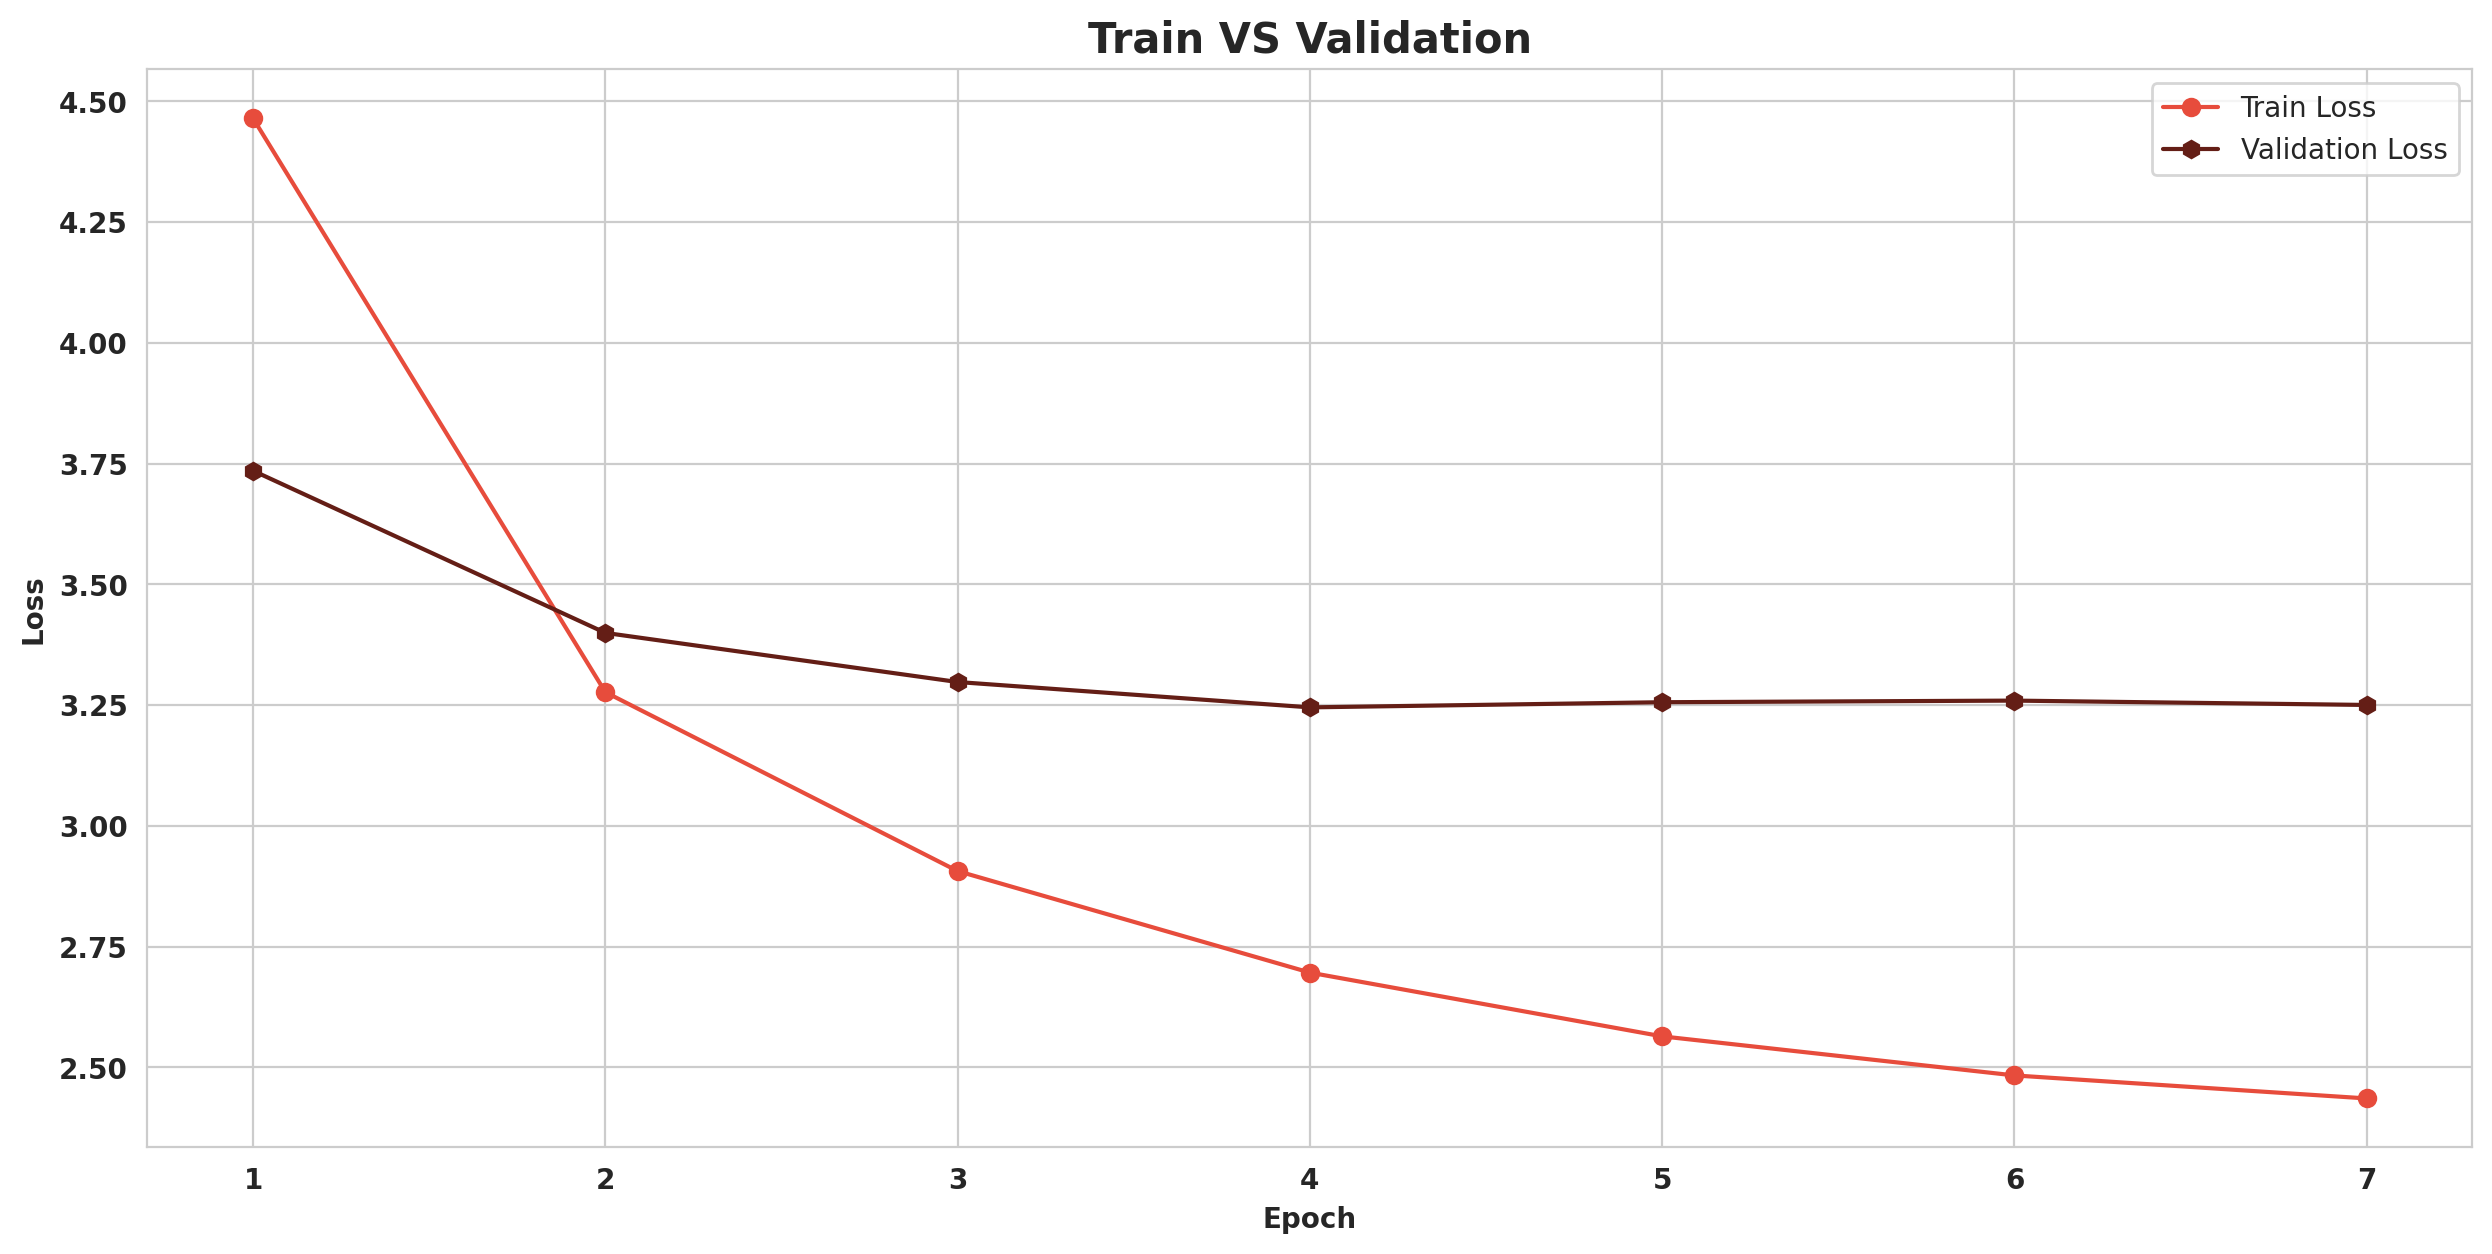

In [28]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

In [29]:
def greedy_generator(image_features):
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1,max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word[idx]
        in_text += ' ' + word
        if word == 'end':
            break

    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')

    return in_text

In [30]:
def beam_search_generator(image_features, K_beams = 3, log = False):
    start = [tokenizer.word_index['start']]
    start_word = [[start, 0.0]]
    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_caption_length).reshape((1,max_caption_length))
            preds = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
            word_preds = np.argsort(preds[0])[-K_beams:]
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-K_beams:]

    start_word = start_word[-1][0]
    captions_ = [tokenizer.index_word[i] for i in start_word]
    final_caption = []
    for i in captions_:
        if i != 'end':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [31]:
from nltk.translate.bleu_score import corpus_bleu

def BLEU_score(actual, greedy, beam_search):
    score_greedy_1 = corpus_bleu(actual, greedy, weights=(0.3, 0.3, 0.3, 0))
    score_greedy_2 = corpus_bleu(actual, greedy, weights=(0.25, 0.25, 0.25, 0.25))
    score_BS_1 = corpus_bleu(actual, beam_search, weights=(0.3, 0.3, 0.3, 0))
    score_BS_2 = corpus_bleu(actual, beam_search, weights=(0.25, 0.25, 0.25, 0.25))

    return [
        (f'BLEU-2 Greedy: {round(score_BS_2, 5)}'),
        (f'BLEU-1 Greedy: {round(score_BS_1, 5)}'),
        (f'Greedy: {greedy[0]}'),
        (f'BLEU-2 Beam Search: {round(score_greedy_2, 5)}'),
        (f'BLEU-1 Beam Search: {round(score_greedy_1, 5)}'),
        (f'Beam Search:  {beam_search[0]}')
    ]

In [32]:
generated_captions = {}

pbar = tqdm_notebook(total=len(test_image_features), position=0, leave=True, colour='green')
for image_id in test_image_features:
    cap = greedy_generator(test_image_features[image_id])
    generated_captions[image_id] = cap
    pbar.update(1)

pbar.close()

  0%|          | 0/122 [00:00<?, ?it/s]

In [33]:
def visualization(data, greedy_caps, beamS_generator, evaluator, num_of_images):
    keys = list(data.keys())
    images = [np.random.choice(keys) for i in range(num_of_images)] # Randomly selected images
    count = 1
    fig = plt.figure(figsize=(6,20))
    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace("start ", "") for x in actual_cap]
        actual_cap = [x.replace(" end", "") for x in actual_cap]

        greedy_cap = greedy_caps[filename]
        beamS_cap = beamS_generator(test_image_features[filename])

        caps_with_score = evaluator(actual_cap, [greedy_cap]*(len(actual_cap)), [beamS_cap]*(len(actual_cap)))

        image_load = load_img(images_directory+filename, target_size=(199,199,3))
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0,i,text,fontsize=10)
        count += 1
    plt.show()



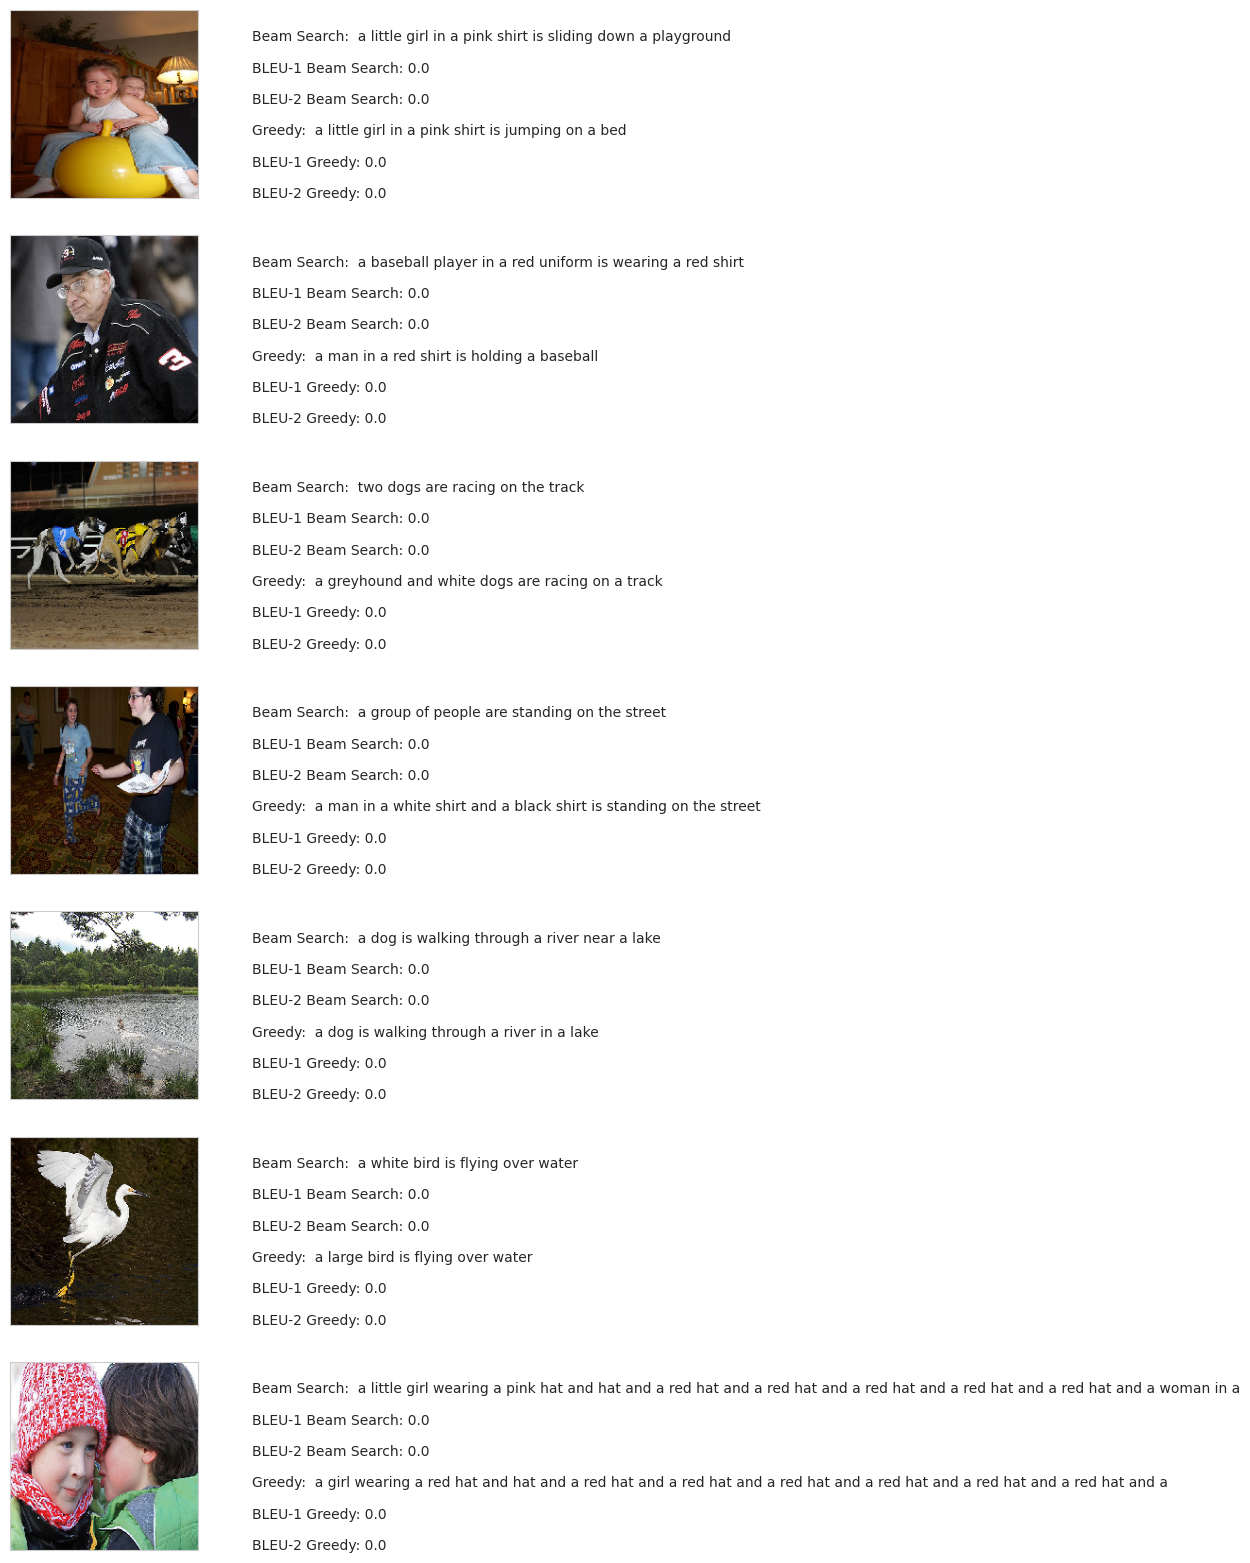

In [34]:
test_actual_captions = {}
for caption_entry in test_captions:
    image_id, caption = caption_entry.split('\t')
    image_id = image_id.strip() # Remove any leading/trailing whitespace
    caption = caption.replace('start ', '').replace(' end', '').strip() # Clean caption
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption)


# Now call the visualization function with the created dictionary
visualization(test_actual_captions, generated_captions, beam_search_generator, BLEU_score, 7)

In [35]:
import pickle
import os

# Define the directory to save the assets
assets_dir = '/content/drive/MyDrive/model_assets'
os.makedirs(assets_dir, exist_ok=True)

# Save the tokenizer
with open(os.path.join(assets_dir, 'tokenizer.pkl'), 'wb') as f:
    pickle.dump(tokenizer, f)

# Save model configuration parameters
model_config = {
    'max_caption_length': max_caption_length,
    'cnn_output_dim': cnn_output_dim
}

with open(os.path.join(assets_dir, 'model_config.pkl'), 'wb') as f:
    pickle.dump(model_config, f)

print(f"✅ Tokenizer and model configuration saved to {assets_dir} successfully!")

✅ Tokenizer and model configuration saved to /content/drive/MyDrive/model_assets successfully!


Now that the tokenizer and model configuration are saved, here is the `app.py` code for deploying your image captioning model with Gradio on Hugging Face Spaces. Make sure to place this `app.py` file in the root of your Hugging Face Space repository, along with the saved `caption_model_final.h5` model, `tokenizer.pkl`, and `model_config.pkl` files (which you should move from `/content/drive/MyDrive/model_assets` to the space's root directory).

In [36]:
import gradio as gr
import tensorflow as tf
import numpy as np
import os
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

# --- Configuration paths (assuming files are in the same directory as app.py) ---
MODEL_PATH = "/content/drive/MyDrive/model/caption_model_final.keras"
TOKENIZER_PATH = "/content/drive/MyDrive/model_assets/tokenizer.pkl"
CONFIG_PATH = "/content/drive/MyDrive/model_assets/model_config.pkl"

# --- Load configurations ---
# Ensure these files are moved to your Hugging Face Space root directory
with open(CONFIG_PATH, 'rb') as f:
    config = pickle.load(f)
max_caption_length = config['max_caption_length']
cnn_output_dim = config['cnn_output_dim']

# --- Load tokenizer ---
with open(TOKENIZER_PATH, 'rb') as f:
    tokenizer = pickle.load(f)
vocab_size = len(tokenizer.word_index) + 1 # Needed for embedding layer if reloading model

# --- Load the pre-trained InceptionV3 model for feature extraction ---
inception_v3_model = InceptionV3(weights='imagenet', input_shape=(299, 299, 3))
inception_v3_model = tf.keras.Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)

# --- Load the captioning model ---
# Ensure 'caption_model_final.h5' is in your Hugging Face Space root directory
caption_model = load_model(MODEL_PATH, safe_mode=False)


# --- Define utility functions ---
def preprocess_image(image_pil):
    # Gradio's gr.Image(type="pil") returns a PIL Image
    img = image_pil.resize((299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def extract_image_features(model, image_pil):
    img_processed = preprocess_image(image_pil)
    features = model.predict(img_processed, verbose=0)
    return features.flatten() # Flatten to match training data


def greedy_generator(image_features):
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1, max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1, cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word[idx]
        in_text += ' ' + word
        if word == 'end':
            break

    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')
    return in_text

def beam_search_generator(image_features, K_beams=3):
    start = [tokenizer.word_index['start']]
    start_word = [[start, 0.0]]
    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            sequence = pad_sequences([s[0]], maxlen=max_caption_length).reshape((1, max_caption_length))
            preds = caption_model.predict([image_features.reshape(1, cnn_output_dim), sequence], verbose=0)
            word_preds = np.argsort(preds[0])[-K_beams:]
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += np.log(preds[0][w])  # Use log probabilities for numerical stability
                temp.append([next_cap, prob])

        start_word = temp
        # Sort by probability (higher is better for log-probs) and keep top K_beams
        start_word = sorted(start_word, reverse=True, key=lambda l: l[1])
        start_word = start_word[:K_beams]

    best_caption_sequence = start_word[0][0]
    captions_ = [tokenizer.index_word[i] for i in best_caption_sequence]
    final_caption = []
    for i in captions_:
        if i != 'end':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption


# --- Gradio Interface Function ---
def generate_captions_gradio(image):
    if image is None:
        return "Please upload an image.", "Please upload an image."

    # Ensure image is in PIL format as expected by preprocess_image
    # Gradio gr.Image(type="pil") handles this automatically if type is set

    image_features = extract_image_features(inception_v3_model, image)

    greedy_cap = greedy_generator(image_features)
    beam_cap = beam_search_generator(image_features, K_beams=3)

    return greedy_cap, beam_cap


# --- Gradio App ---
iface = gr.Interface(
    fn=generate_captions_gradio,
    inputs=gr.Image(type="pil", label="Upload an Image"),
    outputs=[
        gr.Textbox(label="Greedy Search Caption"),
        gr.Textbox(label="Beam Search (K=3) Caption")
    ],
    title="Image Captioning Model",
    description="Upload an image and get its generated captions using Greedy Search and Beam Search (K=3) algorithms.",
    examples=[
        # You can add example image paths here for your Hugging Face Space
        # e.g., "./example_images/test_image_1.jpg",
        # ensure example images are in a folder named 'example_images' in your space
    ],
    allow_flagging="never" # Optional: disable flagging
)

iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://28b813e197567904e3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
